In [3]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [4]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )

In [5]:
data = pd.read_csv('../data/chimpanzees.csv', sep=';')
data.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


**10.1.1. Logistic regression: Prosocial chimpanzees.**

In [6]:
with pm.Model() as model_intercept:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.invlogit(alpha))
    
    l = pm.Binomial('l', n=1, p=p, observed=data.pulled_left.values)
    
    model_intercept.name = 'intercept only'
    model_intercept.trace = pm.sample(5000, tune=1000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1394.00draws/s]


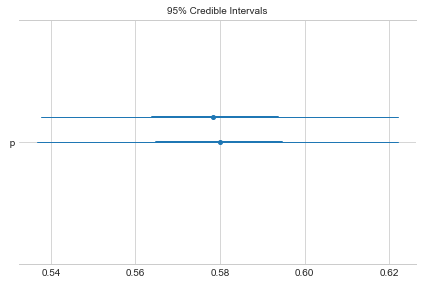

In [9]:
pm.forestplot(model_intercept.trace, varnames=['p'], rhat=False)
None

In [11]:
with pm.Model() as model_linear:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)

    _logit_p = alpha + beta * data.prosoc_left.values
    p = pm.Deterministic('p', pm.math.invlogit(_logit_p))

    l = pm.Binomial('l', n=1, p=p, observed=data.pulled_left.values)

    model_linear.name = 'simple linear'
    model_linear.trace = pm.sample(5000, chains=2, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:19<00:00, 624.66draws/s]


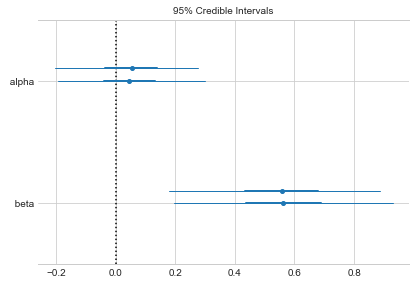

In [12]:
pm.forestplot(model_linear.trace, varnames=['alpha', 'beta', ], rhat=False)
None

In [13]:
agg_prediction(model_linear.trace['p'], data, ['prosoc_left'], summarize())

,prosoc_left,mean_,lower,upper
0,0,0.511945,0.448896,0.570680
1,1,0.647137,0.586931,0.705427


In [14]:
with pm.Model() as model_inter:
    alpha = pm.Normal('alpha', mu=0, sd=10)

    beta_p = pm.Normal('beta_p', mu=0, sd=10)
    beta_c = pm.Normal('beta_c', mu=0, sd=10)

    _logit_p = alpha + (beta_p + beta_c * data.condition.values) * data.prosoc_left.values
    
    p = pm.Deterministic('p', pm.math.invlogit(_logit_p))

    l = pm.Binomial('l', n=1, p=p,
                    observed=data.pulled_left.values)

    model_inter.name = 'interaction'
    model_inter.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_c, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:18<00:00, 645.49draws/s]


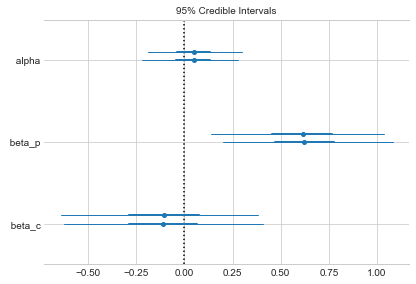

In [15]:
pm.forestplot(model_inter.trace, varnames=['alpha', 'beta_p', 'beta_c'], rhat=False)
None

In [16]:
agg_prediction(model_inter.trace['p'], data, ['prosoc_left', 'condition'], summarize())

,prosoc_left,condition,mean_,lower,upper
0,0,0,0.511650,0.450456,0.573982
1,0,1,0.511650,0.450456,0.573982
2,1,0,0.658862,0.577280,0.742455
3,1,1,0.634426,0.548173,0.715199


In [17]:
comparison = pm.compare({
        model_intercept: model_intercept.trace,
        model_linear: model_linear.trace,
        model_inter: model_inter.trace,
    },
    method='BB-pseudo-BMA'
)

comparison

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
simple linear,680.6,2.05,0,0.6,9.27,0,0
interaction,682.42,3.04,1.83,0.26,9.36,0.83,0
intercept only,687.91,0.98,7.31,0.14,7.09,6.18,0


In [18]:
nsamples = (comparison.weight / comparison.weight.max() * 10000).astype('int')
nsamples

simple linear     10000
interaction        4333
intercept only     2333
Name: weight, dtype: int64

In [19]:
mix = pd.concat(
    [pd.DataFrame(model_linear.trace['p']).sample(nsamples['simple linear']),
     pd.DataFrame(model_intercept.trace['p']).sample(nsamples['intercept only']),
     pd.DataFrame(model_inter.trace['p']).sample(nsamples['interaction'])],
    ignore_index=True
)

mix = agg_prediction(mix, data, ['condition', 'prosoc_left'], summarize())
mix

,condition,prosoc_left,mean_,lower,upper
0,0,0,0.511754,0.447731,0.570046
1,0,1,0.650608,0.581372,0.719332
2,1,0,0.511666,0.448182,0.570006
3,1,1,0.643255,0.570054,0.708814


**individual variation**

In [20]:
data.actor.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [21]:
with pm.Model() as model_indiv:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=data.actor.nunique())

    beta_p = pm.Normal('beta_p', mu=0, sd=10)
    beta_c = pm.Normal('beta_c', mu=0, sd=10)

    alpha_i = alpha[data.actor.values - 1]
    logit_p = alpha_i + (beta_p + beta_c * data.condition.values) * data.prosoc_left.values

    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    l = pm.Binomial('l', n=1, p=p, observed=data.pulled_left.values)
    
    model_indiv.name = 'individual'
    model_indiv.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_c, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:57<00:00, 209.61draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
comparison = pm.compare({
    model_intercept: model_intercept.trace,
    model_linear: model_linear.trace,
    model_inter: model_inter.trace,
    model_indiv: model_indiv.trace,
}, method='BB-pseudo-BMA')

comparison

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
individual,529.75,8.27,0,1,19.57,0,0
simple linear,680.6,2.05,150.84,0,8.98,19.19,0
interaction,682.42,3.04,152.67,0,9.05,19.13,0
intercept only,687.91,0.98,158.15,0,6.97,19.89,0


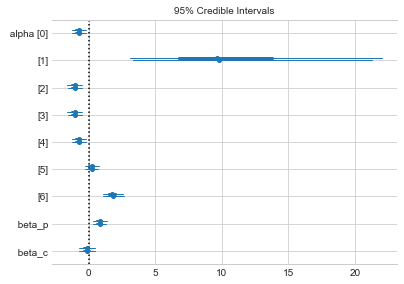

In [24]:
pm.forestplot(model_indiv.trace, varnames=['alpha', 'beta_p', 'beta_c'], rhat=False)
None

**aggregated data source**

In [25]:
data_agg = (
    data
    .groupby(['prosoc_left', 'condition', 'actor'])
    .pulled_left.apply(lambda ser: pd.Series({
            'count_': ser.shape[0],
            'sum_': ser.sum(),
        })
    )
    .unstack().reset_index()
)

data_agg.sample(5)

,prosoc_left,condition,actor,count_,sum_
27,1,1,7,18,18
13,0,1,7,18,17
23,1,1,3,18,6
8,0,1,2,18,18
17,1,0,4,18,9


In [26]:
with pm.Model() as model_agg_indiv:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=data_agg.actor.nunique())
    
    beta_p = pm.Normal('beta_p', mu=0, sd=10)
    beta_c = pm.Normal('beta_c', mu=0, sd=10)

    alpha_i = alpha[data_agg.actor.values - 1]
    logit_p = alpha_i + (beta_p + beta_c * data_agg.condition.values) * data_agg.prosoc_left.values

    p = pm.Deterministic('p', pm.math.invlogit(logit_p))

    l = pm.Binomial('l', p=p, n=data_agg.count_.values,
                    observed=data_agg.sum_.values)

    model_agg_indiv.name = 'agg individual'
    model_agg_indiv.trace = pm.sample(5000, chains=2, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_c, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:41<00:00, 292.09draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.


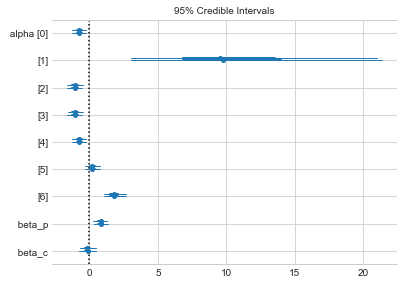

In [27]:
pm.forestplot(model_agg_indiv.trace, varnames=['alpha', 'beta_p', 'beta_c'], rhat=False)
None

**regularization**

In [30]:
with pm.Model() as model_no_infer:
    alpha = pm.Normal('alpha', mu=0, sd=1.5, shape=data_agg.actor.nunique())

    beta_p = pm.Normal('beta_p', mu=0, sd=1)
    beta_c = pm.Normal('beta_c', mu=0, sd=1)

    alpha_i = alpha[data_agg.actor.values - 1]
    logit_p = alpha_i + (beta_p + beta_c * data_agg.condition.values) * data_agg.prosoc_left.values

    p = pm.Deterministic('p', pm.math.invlogit(logit_p))

    trace = pm.sample(500, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_c, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 367.72draws/s]


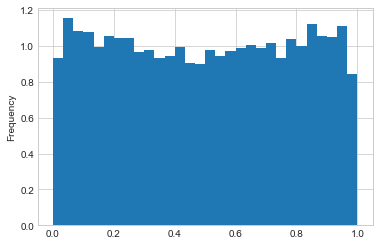

In [31]:
pd.DataFrame(trace['p']).stack().plot.hist(density=True, bins=30)
None

In [32]:
with pm.Model() as model_regul:
    alpha = pm.Normal('alpha', mu=0, sd=1.5, shape=data_agg.actor.nunique())

    beta_p = pm.Normal('beta_p', mu=0, sd=1)
    beta_c = pm.Normal('beta_c', mu=0, sd=1)

    alpha_i = alpha[data_agg.actor.values - 1]
    logit_p = alpha_i + (beta_p + beta_c * data_agg.condition.values) * data_agg.prosoc_left.values

    p = pm.Deterministic('p', pm.math.invlogit(logit_p))

    l = pm.Binomial('l', p=p, n=data_agg.count_.values,
                    observed=data_agg.sum_.values)

    model_regul.name = 'regularized'
    model_regul.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_c, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:20<00:00, 581.04draws/s]


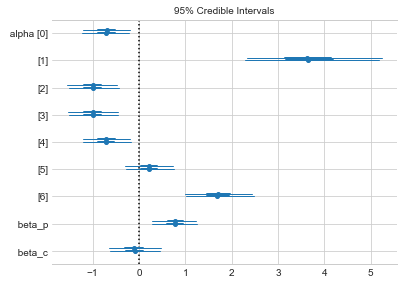

In [33]:
pm.forestplot(model_regul.trace, varnames=['alpha', 'beta_p', 'beta_c'], rhat=False)
None

In [34]:
pm.compare({
        model_agg_indiv: model_agg_indiv.trace,
        model_regul: model_regul.trace,
    }, 
    method='BB-pseudo-BMA'
)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
agg individual,110.49,7.57,0,0.74,10.17,0,1
regularized,113.11,7.44,2.62,0.26,8.58,2.21,1
